In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import warnings

In [21]:
# Suppressing warnings
warnings.filterwarnings("ignore")

set_style("whitegrid")

# Loading the dataset
data_aap = pd.read_csv("C:/Users/Ajay/Downloads/archive (12)/individual_stocks_5yr/individual_stocks_5yr/AAP_data.csv", parse_dates=['date'])
data_aap.drop(columns=['open', 'high', 'low', 'Name', 'volume'], inplace=True)
data_aap.head()

,date,close
0,2013-02-08,78.90
1,2013-02-11,78.39
2,2013-02-12,78.60
3,2013-02-13,78.97
4,2013-02-14,78.84


In [22]:

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_aap_scaled = data_aap.copy()
data_aap_scaled['close'] = scaler.fit_transform(data_aap_scaled[['close']])
data_aap_scaled.head()

,date,close
0,2013-02-08,0.021900
1,2013-02-11,0.017794
2,2013-02-12,0.019485
3,2013-02-13,0.022464
4,2013-02-14,0.021417


In [23]:
# Time Series Cross-Validation
n_splits = 5
tscv = np.array_split(data_aap_scaled, n_splits)

#Defining function for the models that we are going to use, to fit, predict and giving mean square error 
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=0)
    val_predictions = model.predict(X_val)
    return mean_squared_error(y_val, val_predictions), val_predictions

In [24]:

# Sliding Window Linear Regression Model
W = 2  # Window Size
reg = LinearRegression()

def sliding_window_cross_validation(data, window_size, n_splits):
    mse_scores = []
    all_val_predictions = []

    # looping over n_splits, combining training data up to the current split
    # and setting aside the next split as validation data.

    for i in range(n_splits):
        train_data = pd.concat(tscv[:i + 1])
        val_data = tscv[i + 1] if i + 1 < n_splits else tscv[i]

        data_sw = train_data.copy()

        
        for j in range(1, window_size):
            data_sw[f'close_{j}'] = data_sw['close'].shift(j)

        data_sw.dropna(inplace=True)

        predictions_sw = []
        for k in range(window_size - 1):
            predictions_sw.append(0)

        for k in range(window_size - 1, len(data_sw)):
            y_sw = data_sw.iloc[k - (window_size - 1):k + 1]['close']
            reg.fit(np.arange(window_size).reshape(-1, 1), y_sw)
            predictions_sw.append(reg.predict([[window_size]])[0])

        #aligning the lengths of validation data and predictions
        #to ensure their length match and we don't get inconsistent length error.

        val_predictions_sw = predictions_sw[-len(val_data):]
        if len(val_predictions_sw) > len(val_data):
            val_predictions_sw = val_predictions_sw[:len(val_data)]
        elif len(val_predictions_sw) < len(val_data):
            val_data = val_data.iloc[:len(val_predictions_sw)]
        all_val_predictions.extend(val_predictions_sw)
        mse_scores.append(mean_squared_error(val_data['close'], val_predictions_sw))
    return np.mean(mse_scores), all_val_predictions


val_mse_sw, val_predictions_sw = sliding_window_cross_validation(data_aap_scaled, W, n_splits)
print('Sliding Window Linear Regression Validation MSE: {:.10f}'.format(val_mse_sw))

Sliding Window Linear Regression Validation MSE: 0.0803063465


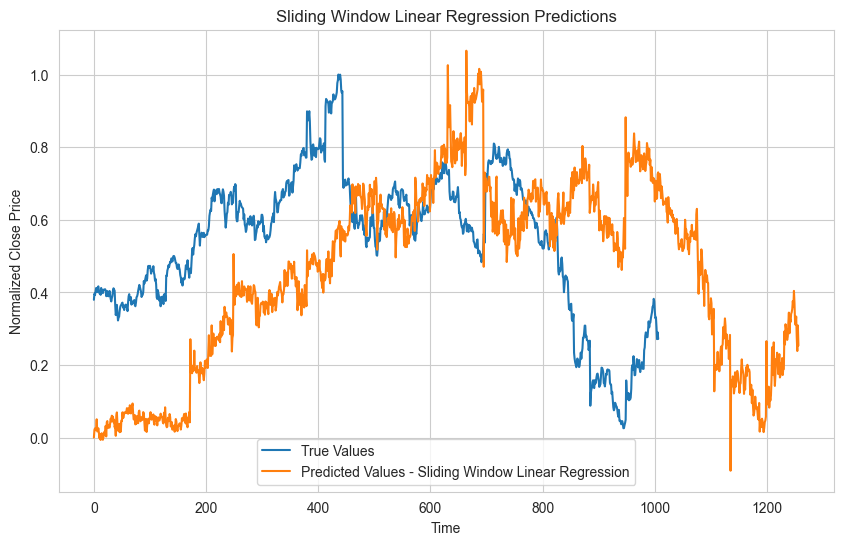

In [25]:
# Extracting validation data for plotting
validation_data = pd.concat(tscv[1:])['close']

# Plotting Sliding Window Linear Regression Predictions
plt.figure(figsize=(10, 6))
plt.plot(validation_data.values, label='True Values')
plt.plot(np.array(val_predictions_sw), label='Predicted Values - Sliding Window Linear Regression')
plt.title('Sliding Window Linear Regression Predictions')
plt.xlabel('Time')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()

In [26]:
# LSTM Model with Time Series Cross-Validation
def lstm_cross_validation(data, window_length, n_splits):
    mse_scores = []
    all_val_predictions = []
    
    for i in range(n_splits):
        
        train_data = pd.concat(tscv[:i + 1]) # Combining training sets
        val_data = tscv[i + 1] if i + 1 < n_splits else tscv[i] # Using next split for validation

        # Preparing for training and validation
        train = train_data['close'].to_numpy().reshape(-1, 1)
        val = val_data['close'].to_numpy().reshape(-1, 1)

        # Normalization
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train = scaler.fit_transform(train)
        scaled_val = scaler.transform(val)

        # Creating sequences for LSTM
        trainX, trainY = [], []
        for j in range(len(scaled_train) - window_length - 1):
            trainX.append(scaled_train[j:j + window_length])
            trainY.append(scaled_train[j + window_length, 0])
        trainX, trainY = np.array(trainX), np.array(trainY)

        valX, valY = [], []
        for j in range(len(scaled_val) - window_length - 1):
            valX.append(scaled_val[j:j + window_length])
            valY.append(scaled_val[j + window_length, 0])
        valX, valY = np.array(valX), np.array(valY)

        # Reshaping data for LSTM input
        trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2])
        valX = valX.reshape(valX.shape[0], valX.shape[1], valX.shape[2])

        # Building the LSTM model
        model = Sequential()
        model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')

        # Training the model and making predictions
        model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=0)
        val_predictions = model.predict(valX)

        # Calculating MSE and store predictions
        mse = mean_squared_error(valY, val_predictions)
        mse_scores.append(mse)
        all_val_predictions.extend(val_predictions.flatten())

    # Returning average MSE and all predictions
    return np.mean(mse_scores), all_val_predictions

window_length = 2
val_mse_lstm, val_predictions_lstm = lstm_cross_validation(data_aap_scaled, window_length, n_splits)
print('LSTM Validation MSE: {:.10f}'.format(val_mse_lstm))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM Validation MSE: 0.0037736828


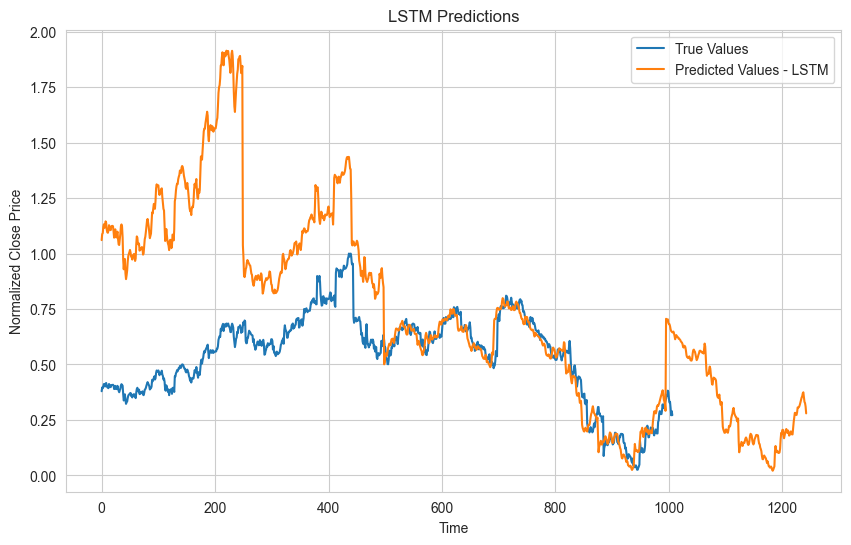

In [27]:
# Plotting LSTM Predictions
plt.figure(figsize=(10, 6))
plt.plot(validation_data.values, label='True Values')
plt.plot(np.array(val_predictions_lstm), label='Predicted Values - LSTM')
plt.title('LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()

In [28]:
# Naive Baseline Model with Time Series Cross-Validation
def naive_baseline_cross_validation(data, n_splits):
    mse_scores = []
    all_val_predictions = []
    for i in range(n_splits):
        train_data = pd.concat(tscv[:i + 1])
        val_data = tscv[i + 1] if i + 1 < n_splits else tscv[i]

        naive_predictions_val = val_data['close'].shift(1).dropna()
        naive_predictions_val = naive_predictions_val[:len(val_data)-1]
        val_close = val_data['close'][1:].values

        mse_scores.append(mean_squared_error(val_close, naive_predictions_val))
        all_val_predictions.extend(naive_predictions_val.values)
    return np.mean(mse_scores), all_val_predictions

naive_mse_val, val_predictions_naive = naive_baseline_cross_validation(data_aap_scaled, n_splits)
print('Naive Baseline Validation MSE: {:.10f}'.format(naive_mse_val))

Naive Baseline Validation MSE: 0.0004630235


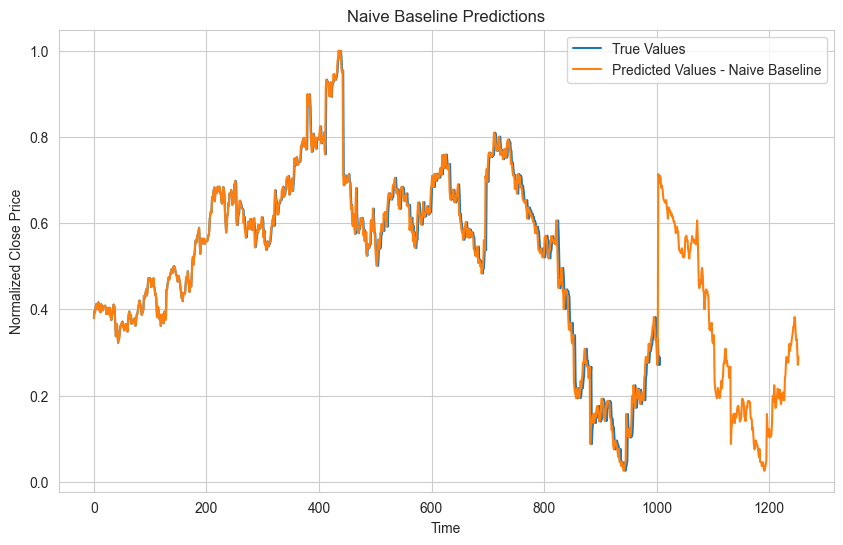

In [29]:
# Plotting Naive Baseline Predictions
plt.figure(figsize=(10, 6))
plt.plot(validation_data.values, label='True Values')
plt.plot(np.array(val_predictions_naive), label='Predicted Values - Naive Baseline')
plt.title('Naive Baseline Predictions')
plt.xlabel('Time')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()


In [31]:


# Comparing Models
min_mse = min(val_mse_sw, val_mse_lstm, naive_mse_val)

if min_mse == val_mse_sw:
    print('The Sliding Window Linear Regression Model is better with a Validation MSE of {:.10f}'.format(val_mse_sw))
elif min_mse == val_mse_lstm:
    print('The LSTM Model is better with a Validation MSE of {:.10f}'.format(val_mse_lstm))
else:
    print('The Naive Baseline Model is better with a Validation MSE of {:.10f}'.format(naive_mse_val))


The Naive Baseline Model is better with a Validation MSE of 0.0004630235
